In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score,precision_score,recall_score,f1_score,mean_absolute_error

# Load data
data = pd.read_csv("central_bank_india.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Calculate Technical Indicators
def calculate_technical_indicators(data):
    # Moving Averages
    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA20'] = data['Close'].rolling(window=20).mean()

    # Relative Strength Index (RSI)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    data['EMA12'] = data['Close'].ewm(span=12, min_periods=0, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=26, min_periods=0, adjust=False).mean()
    data['MACD'] = data['EMA12'] - data['EMA26']

    data['HighMinusLow']= data['High']- data['Low']
    data['OpenMinusClose']= data['Open'] -data['Close']

    data.dropna(inplace=True)
    return data

data.reset_index(drop=True, inplace=True)
data

# Feature Engineering and Technical Indicators
data = calculate_technical_indicators(data)

# Define Classification Criteria
def classify_buy_sell(data):
    data['Buy/Sell'] = np.where((data['Close'] > data['MA5']) &
                                 (data['Close'] > data['MA20']) &
                                 (data['RSI'] > 50) &
                                 (data['MACD'] > 0), 1, -1)
    return data

# Apply Classification Criteria
data = classify_buy_sell(data)

# Prepare features and target for classification
X_cls = data[['RSI', 'MACD','OpenMinusClose','HighMinusLow']]
y_cls = data['Buy/Sell']

# Split data into train and test sets for classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.25, random_state=44)

# Feature Scaling for classification
scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)

# Classifier Model
params_cls = {'n_neighbors': range(2, 16)}
knn_cls = KNeighborsClassifier()
model_cls = GridSearchCV(knn_cls, params_cls, cv=5)
model_cls.fit(X_train_cls_scaled, y_train_cls)

# Classifier Evaluation
accuracy_train_cls = accuracy_score(y_train_cls, model_cls.predict(X_train_cls_scaled))
accuracy_test_cls = accuracy_score(y_test_cls, model_cls.predict(X_test_cls_scaled))
y_pred_cls = model_cls.predict(X_test_cls_scaled)
precision = precision_score(y_test_cls, y_pred_cls)
recall = recall_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls)


print('Classifier Train Data Accuracy: {:.2f}'.format(accuracy_train_cls))
print('Classifier Test Data Accuracy: {:.2f}'.format(accuracy_test_cls))
print('Classifier Precision: {:.2f}'.format(precision))
print('Classifier Recall: {:.2f}'.format(recall))
print('Classifier F1 Score: {:.2f}'.format(f1))

# Regression for Stock Price Prediction

X_reg = data[['RSI', 'MACD','OpenMinusClose','HighMinusLow']]
y_reg = data['Close']

# Split data into train and test sets for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.25, random_state=44)

# Feature Scaling for regression
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Regressor Model
params_reg = {'n_neighbors': range(1, 50)}
knn_reg = KNeighborsRegressor()
model_reg = GridSearchCV(knn_reg, params_reg, cv=10)
model_reg.fit(X_train_reg_scaled, y_train_reg)

# Regression Evaluation
predictions_reg = model_reg.predict(X_test_reg_scaled)
mae_reg = mean_absolute_error(y_test_reg, predictions_reg)
mse_reg = mean_squared_error(y_test_reg, predictions_reg)
rmse_reg = np.sqrt(mean_squared_error(y_test_reg, predictions_reg))
r2_reg = r2_score(y_test_reg, predictions_reg)

print('Regressor RMSE: {:.2f}'.format(rmse_reg))
print('Regressor R2 Score: {:.2f}'.format(r2_reg))
print('Regressor MAE: {:.2f}'.format(mae_reg))
print('Regressor MSE: {:.2f}'.format(mse_reg))


# Predict Stock Price using Regression

Classifier Train Data Accuracy: 0.89
Classifier Test Data Accuracy: 0.85
Classifier Precision: 0.69
Classifier Recall: 0.82
Classifier F1 Score: 0.75
Regressor RMSE: 20.50
Regressor R2 Score: 0.58
Regressor MAE: 14.86
Regressor MSE: 420.44


In [ ]:
valid_knn = pd.DataFrame({'Actual Close': y_test_reg, 'Predicted Close Value': predictions_reg.flatten()})
valid_knn



,Actual Close,Predicted Close Value
2222,103.50,70.372727
938,17.38,34.820000
2204,110.80,64.320909
2105,79.95,76.480909
1496,73.40,94.845455
...,...,...
1320,28.95,70.181818
1027,18.10,24.850000
2453,50.60,67.654545
500,18.50,17.680909


In [ ]:
valid_sorted_knn = valid_knn.sort_index()
valid_sorted_knn

,Actual Close,Predicted Close Value
26,65.79,53.825455
32,67.44,61.507273
39,66.54,70.607273
48,52.96,75.430909
51,51.32,60.411818
...,...,...
2442,53.25,70.231818
2443,53.80,65.813636
2450,50.60,63.022727
2453,50.60,67.654545


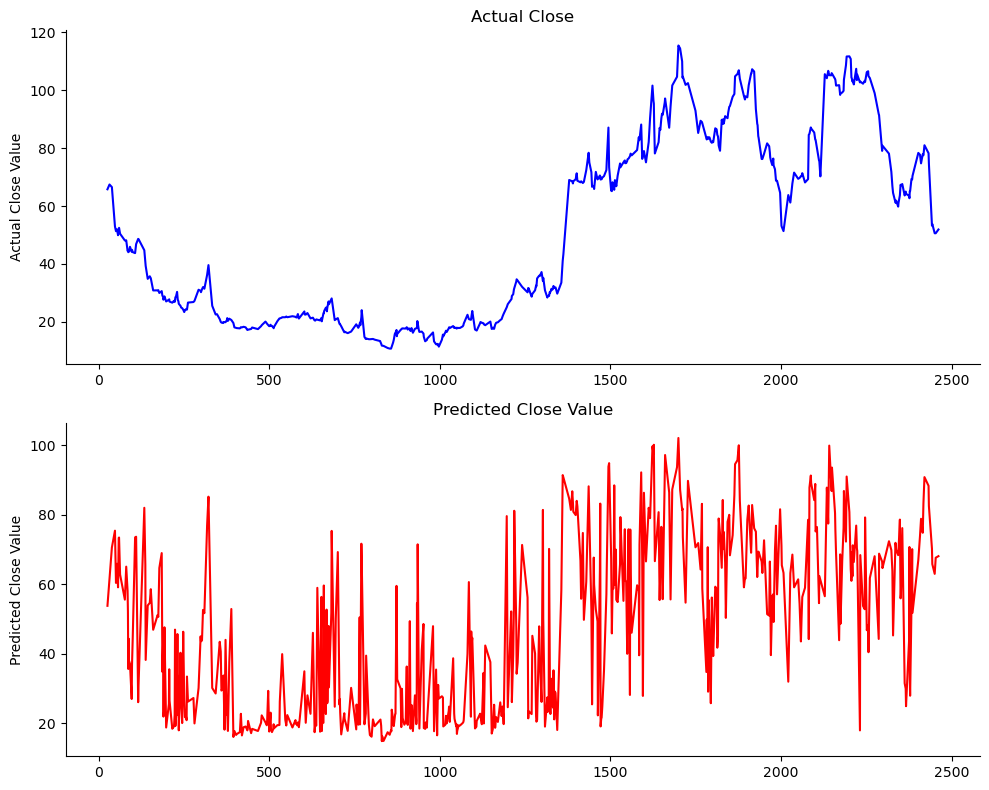

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

valid_sorted_knn['Actual Close'].plot(ax=ax1, kind='line', title='Actual Close', color='blue')
ax1.set_ylabel('Actual Close Value')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

valid_sorted_knn['Predicted Close Value'].plot(ax=ax2, kind='line', title='Predicted Close Value', color='red')
ax2.set_ylabel('Predicted Close Value')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

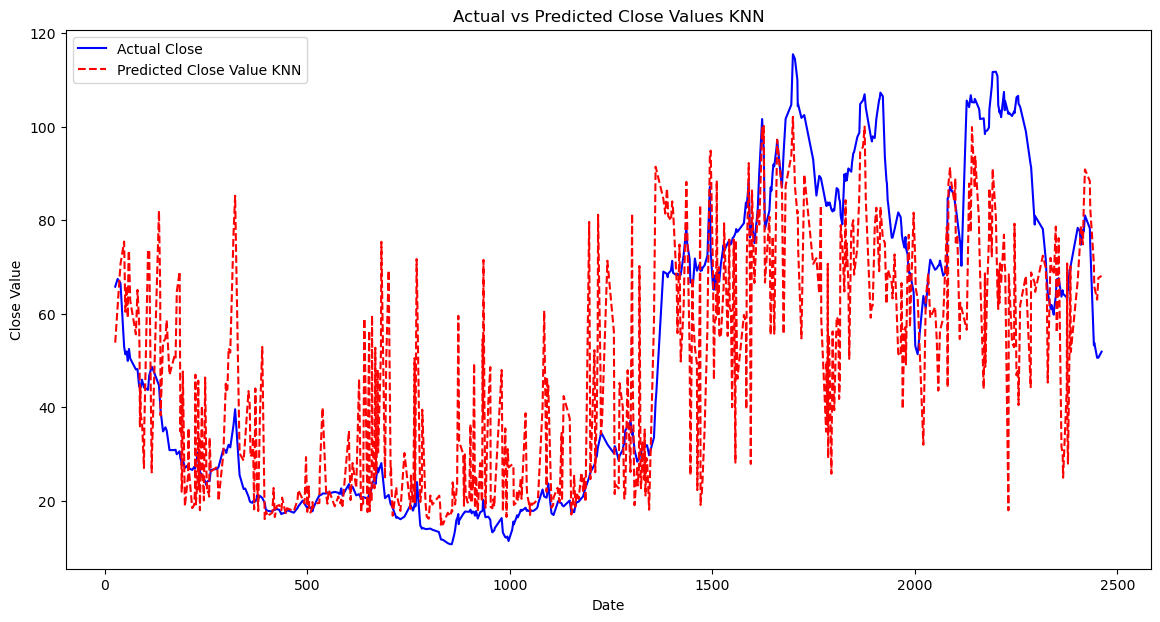

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(valid_sorted_knn.index, valid_sorted_knn['Actual Close'], label='Actual Close', color='blue')
plt.plot(valid_sorted_knn.index, valid_sorted_knn['Predicted Close Value'], label='Predicted Close Value KNN', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Actual vs Predicted Close Values KNN')
plt.legend()
plt.show()
